In [1]:
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV,
    BayesianRidge,
    Ridge,
    ElasticNetCV,
    ElasticNet,
    Lasso,
    LassoCV,
    LarsCV,
    LassoLarsCV,
    SGDRegressor,
    TheilSenRegressor,
    RANSACRegressor,
)
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, RepeatedKFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage_dimm2/kaggle_output/commonlitreadabilityprize")

In [2]:
model_folders = [
    # cherubic-nifty-serval - deberta-large - 0.4836
    "20210614-173633",
    "20210614-203831",
    "20210614-234025",
    "20210615-024138",
    "20210615-054256",
    # scrupulous-mink-of-amplitude - deberta-base - 0.4934
    "20210615-084357",
    "20210615-094729",
    "20210615-105329",
    "20210615-120001",
    "20210615-130640",
    # notorious-sticky-gibbon - roberta-base (with hidden) - 0.4961
    "20210615-220146",
    "20210615-225055",
    "20210615-234038",
    "20210616-003038",
    "20210616-012048",
    # fortunate-cherry-mandrill - roberta-large - 0.4890
    "20210616-021135",
    "20210616-041221",
    "20210616-060255",
    "20210616-075451",
    "20210616-094506",
    # mottled-certain-caracal - distilroberta-base - 0.5076
    "20210616-113626",
    "20210616-121203",
    "20210616-124738",
    "20210616-132341",
    "20210616-140300",
    # aspiring-classic-pegasus - funnel - 0.4975
    "20210617-083847", 
    "20210617-102611", 
    "20210617-120949", 
    "20210617-135233", 
    "20210617-153459", 
    # silver-bumblebee-of-attack - roberta-base - 0.4932
    "20210617-223340",
    "20210617-232650",
    "20210618-002022",
    "20210618-011405",
    "20210618-020751",
    # sloppy-resourceful-tanuki - albert-large - 0.5241
    "20210617-225903",
    "20210618-010302",
    "20210618-030706",
    "20210618-051049",
    "20210618-071437",
    # rustling-quirky-mastodon - bert-base-uncased - 0.5136
    "20210618-082756",
    "20210618-092115",
    "20210618-100526",
    "20210618-105909",
    "20210618-115253",
    # perky-defiant-husky - bert-large-uncased - 0.5287
    "20210618-124637",
    "20210618-144213",
    "20210618-163942",
    "20210618-183719",
    "20210618-203441",
    # gregarious-brass-perch - bart-base - 0.5445
    "20210618-223208",
    "20210618-233614",
    "20210619-004022",
    "20210619-014809",
    "20210619-025421",
    # military-firefly-of-apotheosis - bart-large - 0.5301
    "20210619-035747",
    "20210619-064351",
    "20210619-093050",
    "20210619-121916",
    "20210619-150740",
    # eccentric-lemur-of-tenacity - sentence-transformers/LaBSE - 0.5230
    "20210622-152356",
    "20210622-161822",
    "20210622-171312",
    "20210622-181238",
    "20210622-191326",
    # valiant-chameleon-of-chaos - sentence-transformers/bert-base-nli-cls-token - 0.5288
    "20210622-165808",
    "20210622-174555",
    "20210622-183427",
    "20210622-192221",
    "20210622-201127",
    # nonchalant-quaint-termite - roberta-base - 0.4951
    "20210623-093223",
    "20210623-101956",
    "20210623-110954",
    "20210623-120004",
    "20210623-125025",
    # skilled-smart-crane - deberta-large (new seeds) - 0.4758
    "20210623-105940",
    "20210623-140343",
    "20210623-170657",
    "20210623-201514",
    "20210623-232231",
    # winged-cerise-agouti - roberta-large - 0.4986
    "20210623-134115",
    "20210623-153240",
    "20210623-172217",
    "20210623-191151",
    "20210623-210342",
    # swift-of-amazing-pride - distilroberta-base - 0.5053
    "20210623-225426",
    "20210623-233019",
    "20210624-000706",
    "20210624-004429",
    "20210624-012102",
    # independent-discerning-earthworm - albert-large-v2
    "20210624-015812",
    "20210624-040309",
    "20210624-060838",
    "20210624-081317",
    "20210624-101855",
    # discreet-visionary-seahorse - microsoft/deberta-base - 0.5181
    "20210624-023057",
    "20210624-033624",
    "20210624-044356",
    "20210624-055212",
    "20210624-070123",
    # chirpy-wren-of-unity - funnel-transformer/large-base - 0.5000
    "20210624-081031",
    "20210624-095223",
    "20210624-113506",
    "20210624-131927",
    "20210624-150250",
    # free-ebony-fennec - microsoft/deberta-base - 0.5021
    "20210627-105133",
    "20210627-115742",
    "20210627-130650",
    "20210627-141604",
    "20210627-152616",
    # blond-viper-of-discussion - deepset/roberta-base-squad2 - 0.4900
    "20210627-105144",
    "20210627-114225",
    "20210627-123605",
    "20210627-133047",
    "20210627-142510",
    # meticulous-demonic-kakapo - roberta-large - 0.5030
    "20210627-151904",
    "20210627-171236",
    "20210627-190737",
    "20210627-210244",
    "20210627-225949",
    # fat-glorious-badger - deepset/roberta-large-squad2 - 0.4937
    "20210628-005835",
    "20210628-025632",
    "20210628-045559",
    "20210628-065437",
    "20210628-085322",
    # beautiful-denim-monkey - funnel-transformer/large-base - 0.5066
    "20210627-163614",
    "20210627-181626",
    "20210627-195827",
    "20210627-213946",
    "20210627-232205",
    # solid-zebu-of-happiness - albert-large-v2 - 0.5207
    "20210628-010737",
    "20210628-031447",
    "20210628-052149",
    "20210628-072849",
    "20210628-093543",
    # parrot-of-strange-maturity - sentence-transformers/LaBSE - 0.5286
    "20210628-114738",
    "20210628-125350",
    "20210628-135845",
    "20210628-150440",
    "20210628-161040",
    # greedy-dog-of-holiness - microsoft/deberta-large - 0.4756
    "20210628-114736",
    "20210628-145921",
    "20210628-181426",
    "20210628-212819",
    "20210629-004241",
    # truthful-hissing-waxbill - deepset/sentence_bert - 0.5504
    "20210628-171705",
    "20210628-180837",
    "20210628-190059",
    "20210628-195246",
    "20210628-204527",
    # blazing-natural-husky - bert-large-cased-whole-word-masking - 0.5202
    "20210628-213743",
    "20210628-233312",
    "20210629-012726",
    "20210629-032224",
    "20210629-051503",
    # ludicrous-heron-of-genius - bert-large-cased
    "20210629-035901",
    "20210629-055338",
    "20210629-074730",
    "20210629-094209",
    "20210629-113421",
    # cooperative-mink-of-spirit - xlm-roberta-base
    "20210629-081350",
    "20210629-091723",
    "20210629-102123",
    "20210629-112540",
    "20210629-122949",
    # dangerous-nebulous-horse - xlm-roberta-large - 0.5092
    "20210629-133352",
    "20210629-154453",
    "20210629-183058",
    "20210629-203803",
    "20210629-224305",
    # passionate-sexy-slug - bart-base - 0.5325
    "20210629-132611",
    "20210629-142628",
    "20210629-152921",
    "20210629-163239",
    "20210629-183052",
]

print(len(model_folders))

dataset_paths = [OUTPUT_PATH / f for f in model_folders]

175


In [3]:
mpaths, oof_paths = [], []
for p in dataset_paths:
    mpaths.append(sorted(list(p.glob(f"*/*/*.ckpt"))))
    oof_paths.extend(sorted(list(p.glob(f"*.csv"))))
    
len(model_folders), len(oof_paths)

(175, 175)

In [4]:
oofs = pd.read_csv(INPUT_PATH / "train.csv", usecols=["id", "target", "standard_error"]).sort_values(
        by="id"
    )
for i, (p, f) in enumerate(zip(oof_paths, model_folders)):
    x = pd.read_csv(p).sort_values(by="id")
    oofs[f] = x["prediction"].values

# pred_cols = [f"model_{i}" for i in range(len(mpaths))]
pred_cols = model_folders

print(len(pred_cols))
    
oofs.head()

175


,id,target,standard_error,20210614-173633,20210614-203831,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,...,20210629-133352,20210629-154453,20210629-183058,20210629-203803,20210629-224305,20210629-132611,20210629-142628,20210629-152921,20210629-163239,20210629-183052
1279,000accf7e,-2.002055,0.497274,-2.174165,-2.305160,-2.451190,-2.505858,-2.490587,-2.264506,-2.664520,...,-2.583956,-2.315931,-3.027050,-2.621326,-2.515254,-2.451577,-2.468730,-2.884780,-2.452014,-2.379550
2185,001ef05a9,0.841000,0.492411,0.669889,0.569387,0.472606,0.514734,0.493645,0.528904,0.495011,...,0.242135,0.405947,0.302889,0.533747,0.441790,0.332762,0.530472,0.351958,-0.222108,0.056212
332,00589d631,-2.195109,0.520239,-1.908255,-1.930197,-2.064695,-2.545308,-2.129548,-2.160540,-2.234235,...,-1.593149,-1.991919,-2.067333,-1.879892,-2.165369,-1.925991,-1.862743,-1.684532,-1.590188,-1.733277
72,0060c36b9,-1.333456,0.492384,-1.098570,-1.134784,-1.161226,-1.260594,-1.139692,-0.983574,-1.220255,...,-0.939444,-0.970431,-0.972504,-0.913818,-0.964943,-0.817613,-0.811296,-0.734002,-1.149290,-0.953325
2694,00d4d251d,0.088764,0.463817,-0.226934,-0.034609,-0.219147,-0.192564,0.082993,-0.454333,-0.133543,...,-0.443722,-0.479823,-0.084793,-0.066500,-0.236203,-0.221733,-0.327062,-0.482454,-0.056052,-0.252370


In [5]:
oofs.describe()

,target,standard_error,20210614-173633,20210614-203831,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,20210615-105329,...,20210629-133352,20210629-154453,20210629-183058,20210629-203803,20210629-224305,20210629-132611,20210629-142628,20210629-152921,20210629-163239,20210629-183052
count,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,...,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000
mean,-0.959319,0.491435,-0.948092,-0.939186,-0.936123,-0.968496,-0.958907,-0.891844,-0.910382,-0.932254,...,-0.888617,-0.928521,-0.897443,-0.898815,-0.953352,-0.844883,-0.855846,-0.789732,-0.877770,-0.833569
std,1.033579,0.034818,0.912312,0.889185,0.913707,0.930968,0.905059,0.907261,0.927470,0.911461,...,0.889729,0.907941,0.904612,0.929833,0.915338,0.914740,0.864103,0.916784,0.850334,0.857225
min,-3.676268,0.000000,-3.560785,-3.392829,-3.732013,-3.534283,-3.483280,-3.612729,-3.607502,-3.599687,...,-3.357081,-3.451981,-3.511160,-3.463644,-3.631195,-3.610471,-3.367808,-3.498556,-3.496688,-3.676754
25%,-1.690320,0.468543,-1.613250,-1.570393,-1.616401,-1.659845,-1.625832,-1.550567,-1.581456,-1.592230,...,-1.534121,-1.585187,-1.570862,-1.568221,-1.616437,-1.521959,-1.493594,-1.447201,-1.479983,-1.466526
50%,-0.912190,0.484721,-0.900925,-0.891787,-0.904669,-0.926716,-0.913854,-0.845645,-0.853657,-0.858941,...,-0.833453,-0.854890,-0.829038,-0.823703,-0.901540,-0.774594,-0.795642,-0.717472,-0.838576,-0.770964
75%,-0.202540,0.506268,-0.242909,-0.258008,-0.232878,-0.260776,-0.254002,-0.191775,-0.206128,-0.229850,...,-0.214616,-0.188661,-0.170147,-0.174947,-0.260062,-0.128532,-0.180738,-0.084332,-0.220815,-0.174148
max,1.711390,0.649671,1.249225,1.150385,1.232993,1.288711,1.167053,1.241939,1.432130,1.164523,...,1.255704,1.018389,0.974951,0.959840,1.050956,1.343491,1.152027,1.325483,1.126063,1.355190


In [6]:
# oofs.loc[:, pred_cols].clip(oofs["target"].min(), oofs["target"].max(), inplace=True)

In [7]:
reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000), normalize=False)
reg.fit(oofs[pred_cols], oofs["target"])
print(f"Best score: {np.sqrt(-reg.best_score_):0.5f}. Alpha {reg.alpha_}")
reg.coef_

Best score: 0.45028. Alpha 500.0


array([ 1.82049310e-02, -3.36921744e-04,  1.14232143e-02,  5.94723375e-03,
        1.19208783e-02, -1.08646017e-03,  2.04238680e-02, -6.25008713e-03,
        3.77592484e-03, -1.01553223e-03,  6.99710170e-03,  1.29815554e-02,
        1.26459798e-02, -3.61458101e-03,  8.00717321e-03,  5.26195447e-03,
        2.80121170e-02,  1.89520922e-02,  1.66821529e-02,  1.18027961e-02,
        1.07589987e-02, -5.15340355e-03,  8.03127559e-03,  1.37637023e-02,
       -1.09885036e-03,  1.03739963e-02,  2.19209207e-02,  2.18054314e-02,
        3.28098301e-02,  6.98909234e-03,  9.05761013e-03,  9.75025166e-03,
        8.65048085e-03,  1.91041948e-03, -6.72339179e-03, -2.13739689e-03,
        1.65717185e-02,  1.64613047e-02,  1.03537809e-02, -6.28190453e-03,
        3.47931182e-03,  1.84883720e-02, -2.07407283e-04,  7.96951671e-03,
       -5.49726790e-03, -3.14685923e-04, -9.16613353e-04, -5.28957462e-04,
       -8.55625108e-03, -1.19123277e-02,  1.07811944e-02, -4.05244488e-03,
       -2.93403625e-02, -

In [8]:
# corr = oofs[pred_cols].corr()

# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.9, vmax=1.0, # center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5});

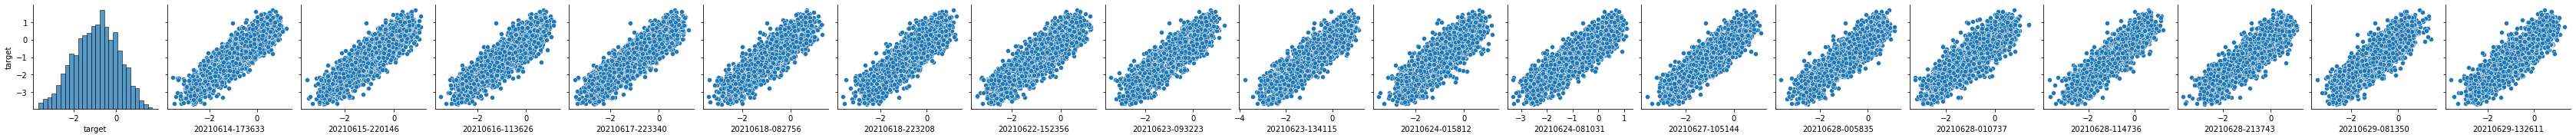

In [9]:
sns.pairplot(oofs, y_vars=["target"], x_vars=["target"] + pred_cols[::10]);

In [10]:
scores = cross_val_score(
#     LinearRegression(),
    Ridge(alpha=100),
#     KernelRidge(alpha=100, kernel="rbf"),
#     BaggingRegressor(n_estimators=100),
#     Lasso(),
    oofs[pred_cols],
    oofs["target"],
    scoring="neg_mean_squared_error",
#     cv=LeaveOneOut(),
    n_jobs=-1,
)
print(f"Best score: {np.sqrt(np.mean(-scores)):0.5f}")

Best score: 0.44981


In [11]:
# # reg = LassoCV(max_iter=5000, cv=LeaveOneOut(), n_jobs=-1)  # 0.45689
# reg = ElasticNetCV(l1_ratio=[0.01, 0.05, .1, .5, .7, .9, .95, .99, 1], max_iter=5000, n_jobs=-1, tol=1e-5)  # 0.45619

# reg.fit(oofs[pred_cols], oofs["target"])
# # print(f"Best score: {np.sqrt(reg.mse_path_[-1].mean()):0.5f}")
# print(reg.l1_ratio_)

# np.sqrt(reg.mse_path_[1, -1].mean())

# Brute force model selection

In [12]:
# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)  # allows duplicate elements
#     return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

# subsets = list(powerset(pred_cols))
# len(subsets)

In [13]:
# best_score = 10
# best_cols = None

# for s in tqdm(subsets[1:]):
#     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
#     reg.fit(oofs[list(s)], oofs["target"])
#     score = np.sqrt(-reg.best_score_)
    
#     if score < best_score:
#         best_score = score
#         best_cols = list(s)
        
# print(f"Best score: {best_score:0.5f}")
# print("Best cols", best_cols)

In [14]:
# ['model_1', 'model_2', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_11', 'model_13', 'model_16']

# Hill climbing

In [15]:
def get_score(X, y):
    #     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000), normalize=True)
    #     reg.fit(X, y)
    #     return np.sqrt(-reg.best_score_)
    reg = LassoCV(
        max_iter=5000,
        random_state=48,
        n_jobs=-1,
        normalize=True,
#         cv=RepeatedKFold(random_state=48),
    ).fit(X, y)
    return np.sqrt(reg.mse_path_)[-1].mean()


def averaging(X, y):
    y_pred = X.mean(1)
    return np.sqrt(mean_squared_error(y_pred, y))

In [16]:
def get_size(folder):
    # Ubuntu uses 1000**3, Kaggle use 1024**3
    return sum(f.stat().st_size for f in (OUTPUT_PATH / folder).rglob('*') if f.is_file()) / 1024**3

In [17]:
# candidates = model_folders.copy()

# best_score = np.inf
# selection = []
# # tol = 0.00001
# tol = 0
# y = oofs["target"]
# storage = 0

# # Find best initial model
# initial_scores = [np.sqrt(mean_squared_error(oofs[c], oofs["target"])) for c in candidates]
# idx = np.argmin(initial_scores)
# best_score = initial_scores[idx]
# selection.append(candidates[idx])
# storage += get_size(candidates[idx])
# print(f"Initial {candidates[idx]}. Score {best_score:0.5f}. {storage:0.1f} GB")
# del candidates[idx]


# while storage < 120:
#     scores = [get_score(oofs[selection + [c]], y) for c in candidates]

#     idx = np.argmin(scores)
#     if scores[idx] < best_score - tol:
#         best_score = scores[idx]
#         selection.append(candidates[idx])
#         storage += get_size(candidates[idx])
#         print(f"Added {candidates[idx]}. New best score {best_score:0.5f}. {storage:0.1f} GB")
#         del candidates[idx]
#     else:
#         break
        
# print(len(selection), "models selected")
        
# selection

# Netflix method

https://kaggler.readthedocs.io/en/latest/_modules/kaggler/ensemble/linear.html#netflix

https://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf

In [18]:
# https://kaggler.readthedocs.io/en/latest/_modules/kaggler/ensemble/linear.html#netflix
def netflix(es, ps, e0, l=.0001):
    """Combine predictions with the optimal weights to minimize RMSE.

    Ref: Töscher, A., Jahrer, M., & Bell, R. M. (2009). The bigchaos solution to the netflix grand prize.

    Args:
        es (list of float): RMSEs of predictions
        ps (list of np.array): predictions
        e0 (float): RMSE of all zero prediction
        l (float): lambda as in the ridge regression

    Returns:
        (tuple):

            - (np.array): ensemble predictions
            - (np.array): weights for input predictions
    """
    m = len(es)
    n = len(ps[0])

    X = np.stack(ps).T
    pTy = .5 * (n * e0**2 + (X**2).sum(axis=0) - n * np.array(es)**2)

    w = np.linalg.pinv(X.T.dot(X) + l * n * np.eye(m)).dot(pTy)

    return X.dot(w), w

In [19]:
# preds = [oofs[c].values for c in selection[:20]]
# rmses = [np.sqrt(mean_squared_error(p, oofs["target"])) for p in preds]

In [20]:
# kf = KFold(5, shuffle=True, random_state=48)

# for i in range(-8, 1):
#     scores = []
#     for fold, (trn_idx, val_idx) in enumerate(kf.split(oofs)):
#         train_oofs = oofs.loc[trn_idx]
#         valid_oofs = oofs.loc[val_idx]

#         train_preds = [train_oofs[c].values for c in selection[:20]]    
#         _, weights = netflix(rmses, train_preds, 1.4100, 10**i)

#         val_pred = valid_oofs[selection[:20]] @ weights
#         score = np.sqrt(mean_squared_error(val_pred, valid_oofs["target"]))
#         scores.append(score)
#         # print(f"Fold {fold}, RMSE: {score:0.5f}")

#     print(f"L: {10**i}, Final RMSE: {np.mean(scores):0.5f}")

# Netflix hillclimb

In [21]:
def get_nf_score(X, y, cv=True):
    if cv:
        scores = []
        for seed in [48, 42, 3]:
            kf = KFold(5, shuffle=True, random_state=seed)

            for fold, (trn_idx, val_idx) in enumerate(kf.split(X)):
                train_oofs = X.loc[trn_idx]
                valid_oofs = X.loc[val_idx]
                valid_target = y.loc[val_idx]

                train_preds = [train_oofs[c].values for c in X.columns]    
                rmses = [np.sqrt(mean_squared_error(X[c], y)) for c in X.columns]
                _, weights = netflix(rmses, train_preds, 1.4100)

                val_pred = valid_oofs @ weights
                score = np.sqrt(mean_squared_error(val_pred, valid_target))
                scores.append(score)

        return np.mean(scores)
    else:
        preds = [X[c].values for c in X.columns] 
        rmses = [np.sqrt(mean_squared_error(X[c], y)) for c in X.columns]
        ensemble, weights = netflix(rmses, preds, 1.4100)
        return np.sqrt(mean_squared_error(ensemble, y))

In [22]:
get_nf_score(oofs[model_folders], oofs["target"])

0.43447596223745577

In [23]:
candidates = model_folders.copy()

best_score = np.inf
selection = []
tol = 0
y = oofs["target"]
storage = 0

# Find best initial model
initial_scores = [np.sqrt(mean_squared_error(oofs[c], y)) for c in candidates]
idx = np.argmin(initial_scores)
best_score = initial_scores[idx]
selection.append(candidates[idx])
storage += get_size(candidates[idx])
print(f"Initial {candidates[idx]}. Score {best_score:0.5f}. {storage:0.1f} GB")
del candidates[idx]


while storage < 150:
    scores = [get_nf_score(oofs[selection + [c]], y, False) for c in candidates]

    idx = np.argmin(scores)
    if scores[idx] < best_score - tol:
        best_score = scores[idx]
        selection.append(candidates[idx])
        storage += get_size(candidates[idx])
        print(f"Added {candidates[idx]}. New best score {best_score:0.5f}. {storage:0.1f} GB")
        del candidates[idx]
    else:
        break
        
print(len(selection), "models selected")
selection  # 0.44098. 96.2 GB

Initial 20210628-145921. Score 0.47120. 7.6 GB
Added 20210624-150250. New best score 0.45940. 14.3 GB
Added 20210616-041221. New best score 0.45466. 20.9 GB
Added 20210623-232231. New best score 0.45216. 28.5 GB
Added 20210624-012102. New best score 0.45052. 30.1 GB
Added 20210619-004022. New best score 0.44885. 32.7 GB
Added 20210617-135233. New best score 0.44752. 39.4 GB
Added 20210619-035747. New best score 0.44654. 47.0 GB
Added 20210624-101855. New best score 0.44563. 47.4 GB
Added 20210628-045559. New best score 0.44480. 54.0 GB
Added 20210618-223208. New best score 0.44417. 56.7 GB
Added 20210624-015812. New best score 0.44365. 57.0 GB
Added 20210627-105144. New best score 0.44323. 59.4 GB
Added 20210627-152616. New best score 0.44282. 62.0 GB
Added 20210618-092115. New best score 0.44244. 63.6 GB
Added 20210624-113506. New best score 0.44211. 70.3 GB
Added 20210627-213946. New best score 0.44181. 77.0 GB
Added 20210615-094729. New best score 0.44152. 79.7 GB
Added 20210614-203

['20210628-145921',
 '20210624-150250',
 '20210616-041221',
 '20210623-232231',
 '20210624-012102',
 '20210619-004022',
 '20210617-135233',
 '20210619-035747',
 '20210624-101855',
 '20210628-045559',
 '20210618-223208',
 '20210624-015812',
 '20210627-105144',
 '20210627-152616',
 '20210618-092115',
 '20210624-113506',
 '20210627-213946',
 '20210615-094729',
 '20210614-203831',
 '20210624-044356',
 '20210628-212819',
 '20210622-152356',
 '20210618-183719',
 '20210628-085322',
 '20210629-183058',
 '20210619-064351',
 '20210617-120949',
 '20210629-163239',
 '20210623-201514']

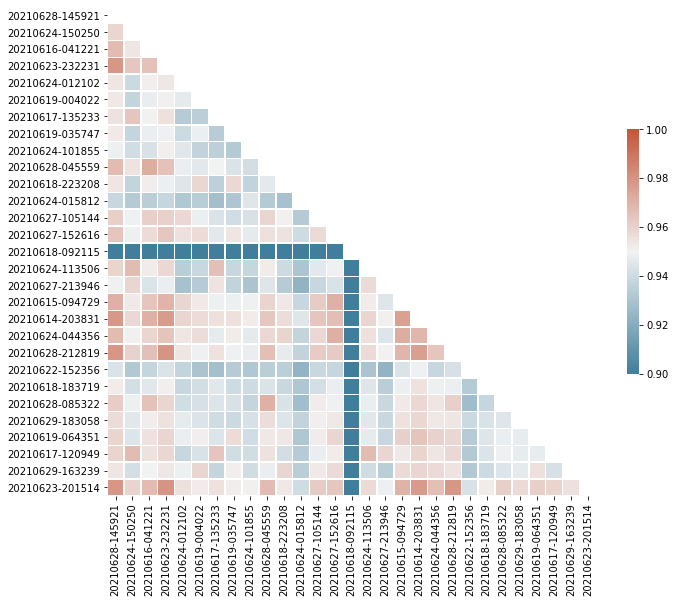

In [24]:
corr = oofs[selection].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.9, vmax=1.0, # center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [25]:
model_folders_current = [
    "20210623-232231",
    "20210616-041221",
    "20210617-135233",
    "20210624-012102",
    "20210619-004022",
    "20210628-045559",
    "20210624-101855",
    "20210624-113506",
    "20210619-035747",
    "20210618-223208",
    "20210615-234038",
    "20210624-015812",
    "20210623-201514",
    "20210624-044356",
    "20210615-094729",
    "20210628-085322",
    "20210619-064351",
    "20210622-152356",
    "20210618-183719",
    "20210627-152616",
    "20210628-031447",
]


model_folders_new = [
    "20210628-145921",
    "20210624-150250",
    "20210616-041221",
    "20210623-232231",
    "20210624-012102",
    "20210619-004022",
    "20210617-135233",
    "20210619-035747",
    "20210624-101855",
    "20210628-045559",
    "20210618-223208",
    "20210624-015812",
    "20210627-105144",
    "20210627-152616",
    "20210618-092115",
    "20210624-113506",
    "20210627-213946",
    "20210615-094729",
    "20210614-203831",
    "20210624-044356",
    "20210628-212819",
#     "20210622-152356",
#     "20210618-183719",
#     "20210628-085322",
#     "20210629-183058",
]

model_folders_current = set(model_folders_current)
model_folders_new = set(model_folders_new)

In [26]:
# Add these. Make colab command
add_list = model_folders_new.difference(model_folders_current)
for d in add_list:
    print(f"upload('{d}')")

upload('20210628-145921')
upload('20210624-150250')
upload('20210614-203831')
upload('20210628-212819')
upload('20210627-105144')
upload('20210627-213946')
upload('20210618-092115')


In [27]:
add_list = model_folders_new.difference(model_folders_current)
for d in add_list:
    print(f"https://www.kaggle.com/anjum48/commonlitreadabilityprize-{d}")

https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210628-145921
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210624-150250
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210614-203831
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210628-212819
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210627-105144
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210627-213946
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210618-092115


In [28]:
# Remove these. Make links
remove_list = model_folders_current.difference(model_folders_new)
for d in remove_list:
    print(f"https://www.kaggle.com/anjum48/commonlitreadabilityprize-{d}")

https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210623-201514
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210615-234038
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210628-031447
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210619-064351
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210628-085322
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210618-183719
https://www.kaggle.com/anjum48/commonlitreadabilityprize-20210622-152356
